
## Models for  Auto MPG Data set



### Model 4

- missing values for `horsepower` replaced with mean of `horsepower`.
- `cylinders`, `model year` and `origin` as category.
- categorical data encoded with get_dummies.
- exclude column `weight` due to high correlation with `displacement`.


## Import libraries/packages

In [1]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

##################################

### ML Models ###
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree.export import export_text
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

##################################

### Metrics ###
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data

In [2]:
# Read the data from the auto-mpg_data-original.csv file.
ds = pd.read_csv("auto-mpg_data-original.csv")

In [3]:
# Examine the data types and the number of non-null items.
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       406 non-null float64
displacement    406 non-null float64
horsepower      400 non-null float64
weight          406 non-null float64
acceleration    406 non-null float64
model year      406 non-null float64
origin          406 non-null float64
car name        406 non-null object
dtypes: float64(8), object(1)
memory usage: 28.7+ KB


In [4]:
# Display the shape of the data.
print("The data frame has {} rows and {} columns.".format(
    ds.shape[0], ds.shape[1]))

The data frame has 406 rows and 9 columns.


In [5]:
# Statistics for the data set.
ds.describe().transpose()

count         mean         std     min      25%     50%  \
mpg           398.0    23.514573    7.815984     9.0    17.50    23.0   
cylinders     406.0     5.475369    1.712160     3.0     4.00     4.0   
displacement  406.0   194.779557  104.922458    68.0   105.00   151.0   
horsepower    400.0   105.082500   38.768779    46.0    75.75    95.0   
weight        406.0  2979.413793  847.004328  1613.0  2226.50  2822.5   
acceleration  406.0    15.519704    2.803359     8.0    13.70    15.5   
model year    406.0    75.921182    3.748737    70.0    73.00    76.0   
origin        406.0     1.568966    0.797479     1.0     1.00     1.0   

                   75%     max  
mpg             29.000    46.6  
cylinders        8.000     8.0  
displacement   302.000   455.0  
horsepower     130.000   230.0  
weight        3618.250  5140.0  
acceleration    17.175    24.8  
model year      79.000    82.0  
origin           2.000     3.0

In [6]:
# Check for duplicate rows.
print(f"There are {ds.duplicated().sum()} duplicate rows in the data set.")

There are 0 duplicate rows in the data set.


In [7]:
# Number of null values for each attribute.
ds.isnull().sum()

mpg             8
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

The rows with a null value from the `mpg` attribute can be seen below:

In [8]:
# Rows with null value at the "mpg" column.
ds[ds['mpg'].isnull()]

mpg  cylinders  displacement  horsepower  weight  acceleration  \
10   NaN        4.0         133.0       115.0  3090.0          17.5   
11   NaN        8.0         350.0       165.0  4142.0          11.5   
12   NaN        8.0         351.0       153.0  4034.0          11.0   
13   NaN        8.0         383.0       175.0  4166.0          10.5   
14   NaN        8.0         360.0       175.0  3850.0          11.0   
17   NaN        8.0         302.0       140.0  3353.0           8.0   
39   NaN        4.0          97.0        48.0  1978.0          20.0   
367  NaN        4.0         121.0       110.0  2800.0          15.4   

     model year  origin                          car name  
10         70.0     2.0              citroen ds-21 pallas  
11         70.0     1.0  chevrolet chevelle concours (sw)  
12         70.0     1.0                  ford torino (sw)  
13         70.0     1.0           plymouth satellite (sw)  
14         70.0     1.0                amc rebel sst (sw)  
17         70.0     1.0             ford mustang boss 302  
39         71.0     2.0       volkswagen super beetle 117  
367        81.0     2.0                         saab 900s

The above rows provide no usefull information because the class attribute value is missing. Hence, we cannot use them as a training nor a test set for our model, so they will be removed them from the dataset. For now, we store them for a potential future use.

In [9]:
# Store rows with a missing value at "mpg" attribute as a prediction set for future use.
prediction_set = ds[ds['mpg'].isnull()].drop('mpg', axis=1)

The rows with null values in the `horsepower` column can be seen below:

In [10]:
# Rows with null value at the "horsepower" column.
ds[ds['horsepower'].isnull()]

mpg  cylinders  displacement  horsepower  weight  acceleration  \
38   25.0        4.0          98.0         NaN  2046.0          19.0   
133  21.0        6.0         200.0         NaN  2875.0          17.0   
337  40.9        4.0          85.0         NaN  1835.0          17.3   
343  23.6        4.0         140.0         NaN  2905.0          14.3   
361  34.5        4.0         100.0         NaN  2320.0          15.8   
382  23.0        4.0         151.0         NaN  3035.0          20.5   

     model year  origin              car name  
38         71.0     1.0            ford pinto  
133        74.0     1.0         ford maverick  
337        80.0     2.0  renault lecar deluxe  
343        80.0     1.0    ford mustang cobra  
361        81.0     2.0           renault 18i  
382        82.0     1.0        amc concord dl

In [11]:
# Fill the null values of "horsepower" with the mean of "horsepower".
ds['horsepower'] = ds['horsepower'].fillna(ds['horsepower'].mean())

In [12]:
# Remove rows from the data set with a null values.
new_ds = ds.dropna()

In [13]:
# Encoding 'cylinders','model year','origin' with get_dummies.
new_ds = pd.get_dummies(new_ds, columns=['cylinders', 'model year', 'origin'])

In [14]:
# Information about the new "clean" data set.
new_ds.info()

# Display the shape of the data.
print("\nThe new data frame has {} rows and {} columns.".format(
    new_ds.shape[0], new_ds.shape[1]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 405
Data columns (total 27 columns):
mpg                398 non-null float64
displacement       398 non-null float64
horsepower         398 non-null float64
weight             398 non-null float64
acceleration       398 non-null float64
car name           398 non-null object
cylinders_3.0      398 non-null uint8
cylinders_4.0      398 non-null uint8
cylinders_5.0      398 non-null uint8
cylinders_6.0      398 non-null uint8
cylinders_8.0      398 non-null uint8
model year_70.0    398 non-null uint8
model year_71.0    398 non-null uint8
model year_72.0    398 non-null uint8
model year_73.0    398 non-null uint8
model year_74.0    398 non-null uint8
model year_75.0    398 non-null uint8
model year_76.0    398 non-null uint8
model year_77.0    398 non-null uint8
model year_78.0    398 non-null uint8
model year_79.0    398 non-null uint8
model year_80.0    398 non-null uint8
model year_81.0    398 non-null uint8
model year

In [15]:
# Statistics for the new data set.
new_ds.describe().transpose()

count         mean         std     min       25%     50%  \
mpg              398.0    23.514573    7.815984     9.0    17.500    23.0   
displacement     398.0   193.425879  104.269838    68.0   104.250   148.5   
horsepower       398.0   104.478631   38.199261    46.0    76.000    95.0   
weight           398.0  2970.424623  846.841774  1613.0  2223.750  2803.5   
acceleration     398.0    15.568090    2.757689     8.0    13.825    15.5   
cylinders_3.0    398.0     0.010050    0.099871     0.0     0.000     0.0   
cylinders_4.0    398.0     0.512563    0.500471     0.0     0.000     1.0   
cylinders_5.0    398.0     0.007538    0.086601     0.0     0.000     0.0   
cylinders_6.0    398.0     0.211055    0.408571     0.0     0.000     0.0   
cylinders_8.0    398.0     0.258794    0.438523     0.0     0.000     0.0   
model year_70.0  398.0     0.072864    0.260241     0.0     0.000     0.0   
model year_71.0  398.0     0.070352    0.256061     0.0     0.000     0.0   
model year_72.0  398.0     0.070352    0.256061     0.0     0.000     0.0   
model year_73.0  398.0     0.100503    0.301047     0.0     0.000     0.0   
model year_74.0  398.0     0.067839    0.251786     0.0     0.000     0.0   
model year_75.0  398.0     0.075377    0.264331     0.0     0.000     0.0   
model year_76.0  398.0     0.085427    0.279868     0.0     0.000     0.0   
model year_77.0  398.0     0.070352    0.256061     0.0     0.000     0.0   
model year_78.0  398.0     0.090452    0.287190     0.0     0.000     0.0   
model year_79.0  398.0     0.072864    0.260241     0.0     0.000     0.0   
model year_80.0  398.0     0.072864    0.260241     0.0     0.000     0.0   
model year_81.0  398.0     0.072864    0.260241     0.0     0.000     0.0   
model year_82.0  398.0     0.077889    0.268335     0.0     0.000     0.0   
origin_1.0       398.0     0.625628    0.484569     0.0     0.000     1.0   
origin_2.0       398.0     0.175879    0.381197     0.0     0.000     0.0   
origin_3.0       398.0     0.198492    0.399367     0.0     0.000     0.0   

                      75%     max  
mpg                29.000    46.6  
displacement      262.000   455.0  
horsepower        125.000   230.0  
weight           3608.000  5140.0  
acceleration       17.175    24.8  
cylinders_3.0       0.000     1.0  
cylinders_4.0       1.000     1.0  
cylinders_5.0       0.000     1.0  
cylinders_6.0       0.000     1.0  
cylinders_8.0       1.000     1.0  
model year_70.0     0.000     1.0  
model year_71.0     0.000     1.0  
model year_72.0     0.000     1.0  
model year_73.0     0.000     1.0  
model year_74.0     0.000     1.0  
model year_75.0     0.000     1.0  
model year_76.0     0.000     1.0  
model year_77.0     0.000     1.0  
model year_78.0     0.000     1.0  
model year_79.0     0.000     1.0  
model year_80.0     0.000     1.0  
model year_81.0     0.000     1.0  
model year_82.0     0.000     1.0  
origin_1.0          1.000     1.0  
origin_2.0          0.000     1.0  
origin_3.0          0.000     1.0

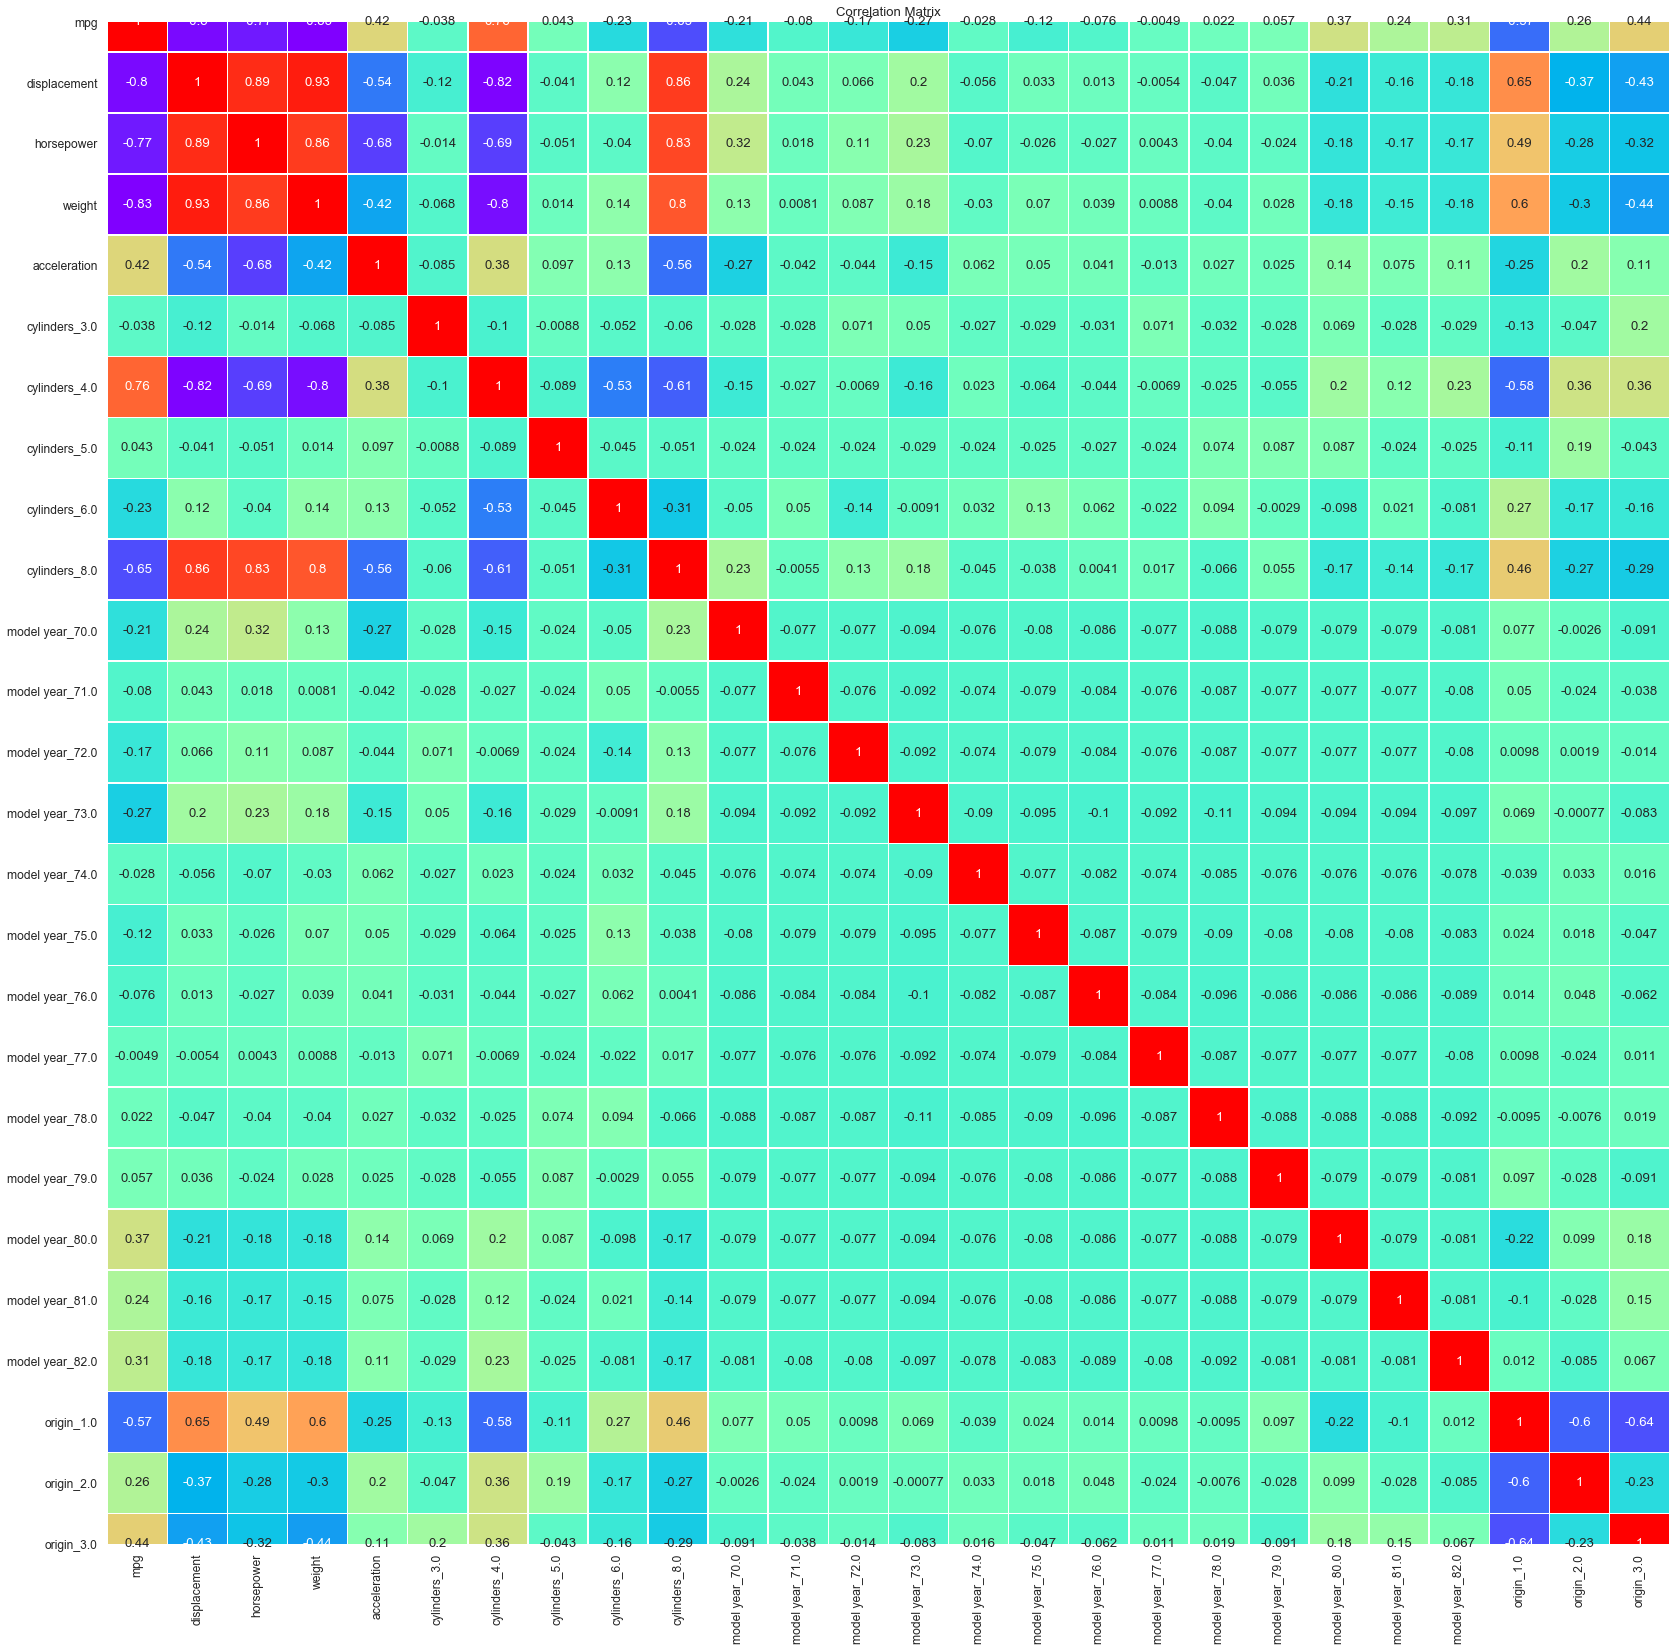

In [16]:
# Plotting a correlation heatmap for the new data set.
corr = new_ds.corr()
plt.figure(figsize=(28, 28))
sns.set(font_scale=1.1)
sns.heatmap(data=corr, annot=True, cbar=False, cmap='rainbow', linewidth=0.5)
plt.title('Correlation Matrix')
plt.show()

## Part 2: Preproccesing
In this part we prepare the data for our models. This means that we choose the columns that will be our independed variables and which column the target that we want to predict. Once we are done with that, we split our data into train and test sets and perfom a standardization upon them.

In [17]:
# Distinguish attribute columns and target column.
X = new_ds[new_ds.columns[1:-1]].drop(columns=['car name', 'weight'])
y = new_ds['mpg']

In [18]:
# Split to train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25)

In [19]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Part 3: Modeling
In this section we build and try 3 models:
- Linear Regression
- Decision tree
- Neural network

Each model will be trained and make a prediction for the test set. Accuracy, precision, recall, f1-score, confusion matrix and ROC will be calculated for each model. Then we will use the GridSearchCV module to tune our models and search for the best hyperparameters in order to increase the accuracy of each model.

## Linear Regression

In [20]:
# Initialize a Logistic Regression estimator.
linreg = LinearRegression(n_jobs=-1)

# Train the estimator.
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [21]:
# Make predictions.
lin_pred = linreg.predict(X_test)

# Calculate CV score.
cv_lin_reg = cross_val_score(linreg, X_train, y_train, cv=10).mean()

## Linear Regression Metrics

In [22]:
# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, lin_pred))

# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" %
      mean_absolute_error(y_test, lin_pred))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.1f' % (cv_lin_reg*100), '%')

# Accuracy score: 1 is perfect prediction.
print('Accuracy: %.1f' % (linreg.score(X_test, y_test)*100), '%')

Mean squared error (MSE): 9.96
Mean absolute error (MAE): 2.26
Cross-validation accuracy: 80.7 %
Accuracy: 83.3 %


## Decision tree

In [23]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeRegressor(max_depth=3, random_state=25)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=25, splitter='best')

Text(0.5, 1.0, 'Decision Tree')

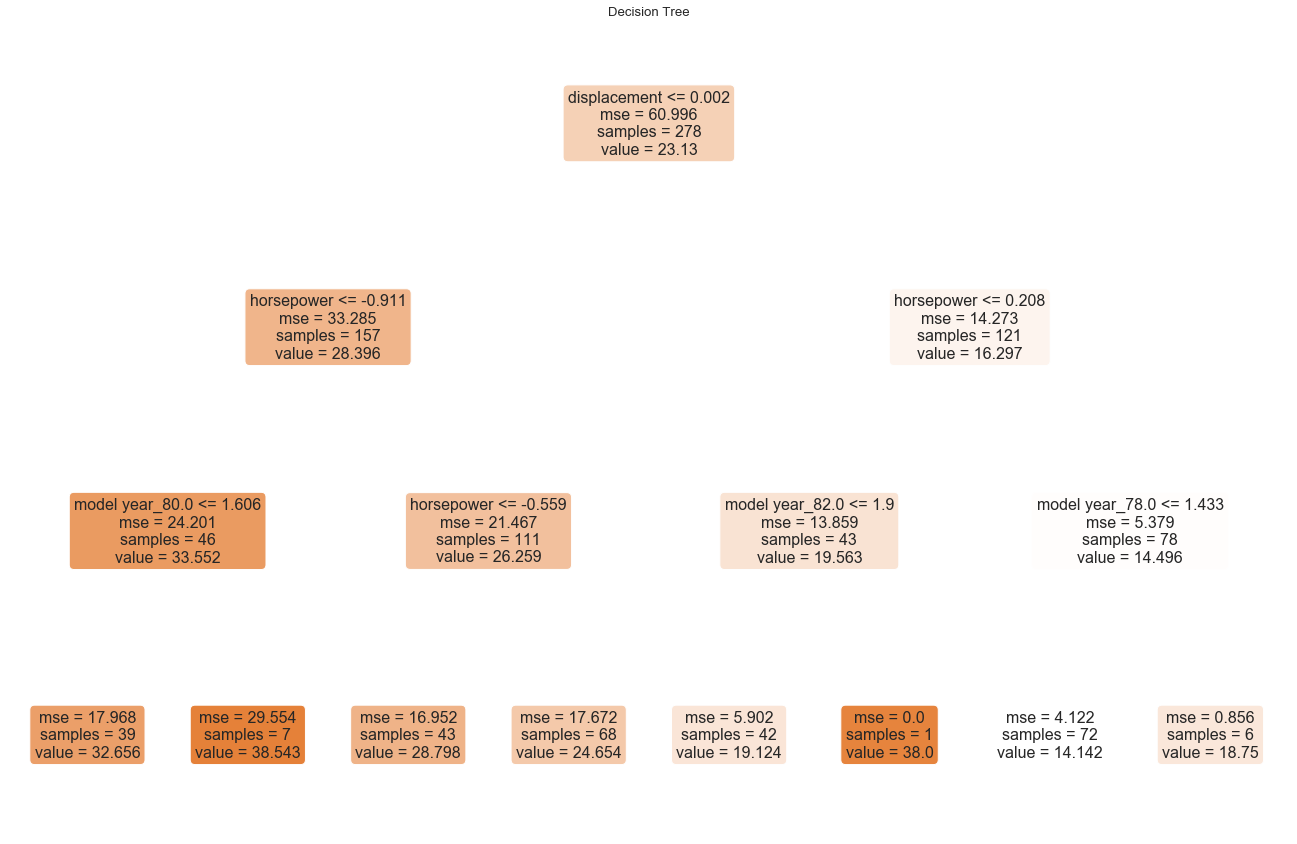

In [24]:
# Plot the tree.
fig = plt.figure(figsize=(23, 15))
tree.plot_tree(tr.fit(X_train, y_train), feature_names=X.columns,
               filled=True, rounded=True, fontsize=16)
plt.title('Decision Tree')

In [25]:
# Print the tree in a simplified version.
r = export_text(tr, feature_names=X.columns.tolist())
print(r)

|--- displacement <= 0.00
|   |--- horsepower <= -0.91
|   |   |--- model year_80.0 <= 1.61
|   |   |   |--- value: [32.66]
|   |   |--- model year_80.0 >  1.61
|   |   |   |--- value: [38.54]
|   |--- horsepower >  -0.91
|   |   |--- horsepower <= -0.56
|   |   |   |--- value: [28.80]
|   |   |--- horsepower >  -0.56
|   |   |   |--- value: [24.65]
|--- displacement >  0.00
|   |--- horsepower <= 0.21
|   |   |--- model year_82.0 <= 1.90
|   |   |   |--- value: [19.12]
|   |   |--- model year_82.0 >  1.90
|   |   |   |--- value: [38.00]
|   |--- horsepower >  0.21
|   |   |--- model year_78.0 <= 1.43
|   |   |   |--- value: [14.14]
|   |   |--- model year_78.0 >  1.43
|   |   |   |--- value: [18.75]



In [26]:
# Make predictions.
tr_pred = tr.predict(X_test)

# Calculate CV score.
cv_tr_reg = cross_val_score(tr, X_train, y_train, cv=10).mean()

## Decision tree Metrics

In [27]:
# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, tr_pred))

# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" % mean_absolute_error(y_test, tr_pred))

# Cross-Validation accuracy.
print('Cross-validation accuracy: %0.1f' % (cv_tr_reg*100), '%')

# Accuracy score: 1 is perfect prediction.
print('Accuracy: %.1f' % (tr.score(X_test, y_test)*100), '%')

Mean squared error (MSE): 19.35
Mean absolute error (MAE): 3.26
Cross-validation accuracy: 68.1 %
Accuracy: 67.6 %


## Neural network (MLP)

In [28]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPRegressor(max_iter=1000, random_state=25, shuffle=True, verbose=False)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=1000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=25, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [29]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# Calculate CV score.
cv_mlp_reg = cross_val_score(mlp, X_train, y_train, cv=10).mean()

## Neural network (MLP) metrics

In [30]:
# Mean squared error (relative error).
print("Mean squared error (MSE): %.2f" % mean_squared_error(y_test, mlp_pred))

# Mean absolute error (average error).
print("Mean absolute error (MAE): %.2f" %
      mean_absolute_error(y_test, mlp_pred))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.1f' % (cv_mlp_reg*100), '%')

# Accuracy score: 1 is perfect prediction.
print('Accuracy: %.1f' % (mlp.score(X_test, y_test)*100), '%')

Mean squared error (MSE): 7.43
Mean absolute error (MAE): 1.95
Cross-validation accuracy: 81.4 %
Accuracy: 87.5 %


## Results

In [31]:
metrics = ['MSE', 'MAE', 'CV accuracy', 'Accuracy']

# Plot metrics.
fig = go.Figure(data=[
    go.Bar(name='Linear Regression', x=metrics, y=[mean_squared_error(
        y_test, lin_pred), mean_absolute_error(y_test, lin_pred), cv_lin_reg, linreg.score(X_test, y_test)]),
    go.Bar(name='Decision tree', x=metrics, y=[mean_squared_error(
        y_test, tr_pred), mean_absolute_error(y_test, tr_pred), cv_tr_reg, tr.score(X_test, y_test)]),
    go.Bar(name='Neural Network', x=metrics, y=[mean_squared_error(
        y_test, mlp_pred), mean_absolute_error(y_test, mlp_pred), cv_mlp_reg, mlp.score(X_test, y_test)])
])

fig.update_layout(title_text='Results',
                  barmode='group', xaxis_tickangle=-45, bargroupgap=0.05)
fig.show()

In [32]:
d = {
    '': ['Linear Regression', 'Decision Tree', 'Neural Network (MLP)'],
    'MSE': [mean_squared_error(y_test, lin_pred), mean_squared_error(y_test, tr_pred), mean_squared_error(y_test, mlp_pred)],
    'MAE': [mean_absolute_error(y_test, lin_pred), mean_absolute_error(y_test, tr_pred), mean_absolute_error(y_test, mlp_pred)],
    'CV Accuracy': [cv_lin_reg, cv_tr_reg, cv_mlp_reg],
    'Accuracy': [linreg.score(X_test, y_test), tr.score(X_test, y_test), mlp.score(X_test, y_test)]
}

results = pd.DataFrame(data=d).round(3).set_index('')
results

MSE    MAE  CV Accuracy  Accuracy
                                                          
Linear Regression      9.957  2.265        0.807     0.833
Decision Tree         19.354  3.259        0.681     0.676
Neural Network (MLP)   7.431  1.945        0.814     0.875

## Quinlan's results

|                   | Mean squared error (MSE) | Mean absolute error (MAE) |
|-------------------|:------------------------:|:-------------------------:|
| Linear Regression |           19.4           |            2.61           |
| Decision tree     |           14.7           |            2.11           |
| Neural Network    |           12.5           |            2.02           |